In [1]:
from jax import numpy as jnp, random, vmap, value_and_grad, jit
import qujax
import matplotlib.pyplot as plt


# Define the classification task<br>
We'll try and learn a _donut_ binary classification function (i.e. a bivariate coordinate is labelled 1 if it is inside the donut and 0 if it is outside)

In [2]:
inner_rad = 0.25
outer_rad = 0.75


def classification_function(x, y):
    r = jnp.sqrt(x**2 + y**2)
    return jnp.where((r > inner_rad) * (r < outer_rad), 1, 0)


In [3]:
linsp = jnp.linspace(-1, 1, 1_000)
Z = vmap(lambda x: vmap(lambda y: classification_function(x, y))(linsp))(linsp)


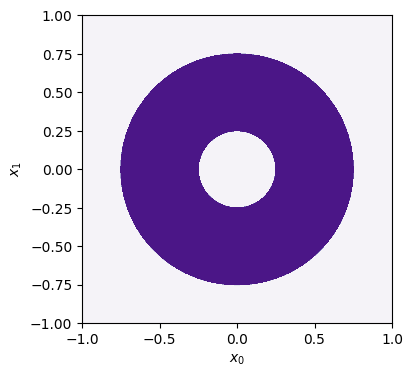

In [4]:
plt.figure(figsize=(4,4))
plt.xlabel(f'$x_0$')
plt.ylabel(f'$x_1$')
plt.contourf(linsp, linsp, Z, cmap='Purples');

Now let's generate some data for our quantum circuit to learn from

In [5]:
n_data = 1_000
x = random.uniform(random.PRNGKey(0), shape=(n_data, 2), minval=-1, maxval=1) # bivariate (x_0,x_1) data
y = classification_function(x[:, 0], x[:, 1])  # ground truth labels


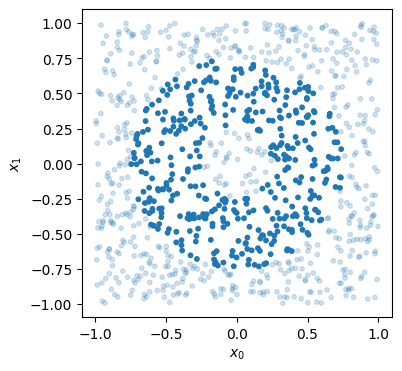

In [6]:
plt.figure(figsize=(4,4))
plt.xlabel(f'$x_0$')
plt.ylabel(f'$x_1$')
plt.scatter(x[:,0], x[:,1], alpha=jnp.where(y, 1, 0.2), s=10);

# Quantum circuit time<br>
We'll use a variant of data re-uploading [Pérez-Salinas et al](https://doi.org/10.22331/q-2020-02-06-226) to encode the input data, alongside some variational parameters within a quantum circuit classifier

In [7]:
n_qubits = 3
depth = 5

In [8]:
gate_seq_seq = []
qubit_inds_seq = []
param_inds_seq = []


pi = 0
for layer in range(depth):
    for qi in range(n_qubits):
        gate_seq_seq += ["Rz", "Ry", "Rz"]
        qubit_inds_seq += [[qi], [qi], [qi]]
        param_inds_seq += [[pi], [pi + 1], [pi + 2]]
        pi += 3

    if layer < (depth - 1):
        for qi in range(layer, layer + n_qubits - 1, 2):
            gate_seq_seq += ["CZ"]
            qubit_inds_seq += [[qi % n_qubits, (qi + 1) % n_qubits]]
            param_inds_seq += [[]]


In [9]:
qujax.print_circuit(gate_seq_seq, qubit_inds_seq, param_inds_seq, gate_ind_max=30);

q0: ---Rz[0]---Ry[1]---Rz[2]-----◯-----Rz[9]---Ry[10]--Rz[11]--Rz[18]--Ry[19]--Rz[20]------------CZ----Rz[27]
                                 |                                                               |           
q1: ---Rz[3]---Ry[4]---Rz[5]-----CZ----Rz[12]--Ry[13]--Rz[14]----◯-----Rz[21]--Ry[22]--Rz[23]----|-----------
                                                                 |                               |           
q2: ---Rz[6]---Ry[7]---Rz[8]---Rz[15]--Ry[16]--Rz[17]------------CZ----Rz[24]--Ry[25]--Rz[26]----◯-----------


We can use `qujax` to generate our angles-to-statetensor function.

We'll parameterise each angle as
$$
    \theta_k = b_k + w_k * x_k
$$
where $b_k, w_k$ are variational parameters to be learnt and $x_k = x_0$ if $k$ even, $x_k = x_1$ if $k$ odd for a single bivariate input point $(x_0, x_1)$.

In [10]:
angles_to_st = qujax.get_params_to_statetensor_func(
    gate_seq_seq, qubit_inds_seq, param_inds_seq
)


In [11]:
n_angles = 3 * n_qubits * depth
n_params = 2 * n_angles

In [12]:
def param_and_x_to_angles(param, x_single):
    biases = param[:n_angles]
    weights = param[n_angles:]

    weights_times_data = jnp.where(
        jnp.arange(n_angles) % 2 == 0, weights * x_single[0], weights * x_single[1]
    )

    angles = biases + weights_times_data
    return angles


In [13]:
param_and_x_to_st = lambda param, x_single: angles_to_st(param_and_x_to_angles(param, x_single))

We'll measure the first qubit only (if it's 1 we label _donut_, if it's 0 we label _not donut_)

In [14]:
def param_and_x_to_probability(param, x_single):
    st = param_and_x_to_st(param, x_single)
    all_probs = jnp.square(jnp.abs(st))  # probabilities of all states given one x datapoint: it is a tensor of shape [2] x n_qubits
    first_qubit_probs = jnp.sum(all_probs, axis=range(1, n_qubits)) # sum over all probabilities related to first qubit
    return first_qubit_probs[1] # probability first qubit is 1


For binary classification, the likelihood for our full data set $(x_{1:N}, y_{1:N})$ is
<br>
$$
p(y_{1:N} \mid b, w, x_{1:N}) = \prod_{i=1}^N p(y_i \mid b, w, x_i) = \prod_{i=1}^N (1 - q_{(b,w)}(x_i))^{\mathbb{I}[y_i = 0]}q_{(b,w)}(x_i)^{\mathbb{I}[y_i = 1]},
$$
<br>

where $q_{(b, w)}(x)$ is the probability the quantum circuit classifies input $x$ as donut given variational parameter vectors $(b, w)$. This gives log-likelihood
<br>
$$
\log p(y_{1:N} \mid b, w, x_{1:N}) = \sum_{i=1}^N \mathbb{I}[y_i = 0] \log(1 - q_{(b,w)}(x_i)) + \mathbb{I}[y_i = 1] \log q_{(b,w)}(x_i),
$$
<br>

which we would like to maximise.

Unfortunately, the log-likelihood **cannot** be approximated unbiasedly using shots, that is we can approximate $q_{(b,w)}(x_i)$ unbiasedly but not $\log(q_{(b,w)}(x_i))$.
Note that in `qujax` simulations we can use the statetensor to calculate this exactly, but it is still good to keep in mind loss functions that can also be used with shots from a quantum device.

On a quantum device we can minimise an expected distance between shots and data
<br>
$$
C(b, w, x, y) = \mathbb{E}_{p(y' \mid q_{(b, w)}(x))}[\ell(y', y)] = (1 - q_{(b, w)}(x)) \ell(0, y) +  q_{(b, w)}(x)\ell(1, y),
$$
<br>

where $y'$ is a shot, $y$ is a data label and $\ell$ is some distance between bitstrings - here we simply set $\ell(0, 0) = \ell(1, 1) = 0$ and $\ell(0, 1) = \ell(1, 0) = 1$ (which coincides with the Hamming distance for this binary example). The full batch cost function is $C(b, w) = \frac1N \sum_{i=1}^N C(b, w, x_i, y_i)$.

Note that to calculate the cost function we need to evaluate the statetensor for every input point $x_i$. If the dataset becomes too large, we can easily minibatch.

In [15]:
def param_to_cost(param):  # use the expected distance as loss function
    donut_probs = vmap(param_and_x_to_probability, in_axes=(None, 0))(param, x) # mapping over x
    costs = jnp.where(y, 1 - donut_probs, donut_probs)
    return costs.mean()


# Ready to descend some gradients?

We'll just use vanilla gradient descent here

In [16]:
param_to_cost_and_grad = jit(value_and_grad(param_to_cost))


In [17]:
n_iter = 1_000
stepsize = 1e-1
param = random.uniform(random.PRNGKey(1), shape=(n_params,), minval=0, maxval=2)
costs = jnp.zeros(n_iter)
for i in range(n_iter):
    cost, grad = param_to_cost_and_grad(param)
    costs = costs.at[i].set(cost)
    param = param - stepsize * grad
    print(i, "Cost: ", cost, end="\r")


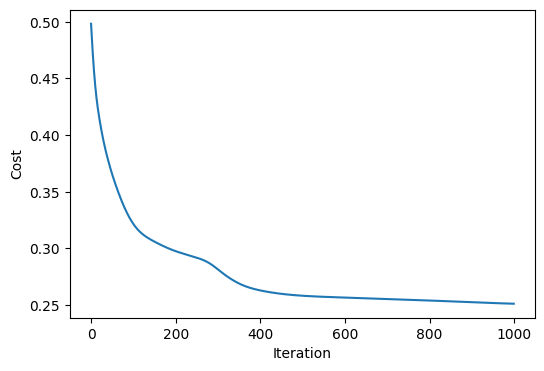

In [18]:
plt.figure(figsize=(6,4))
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost');

# Visualise trained classifier

In [19]:
linsp = jnp.linspace(-1, 1, 100)
Z = vmap(
    lambda a: vmap(lambda b: param_and_x_to_probability(param, jnp.array([a, b])))(
        linsp
    )
)(linsp)


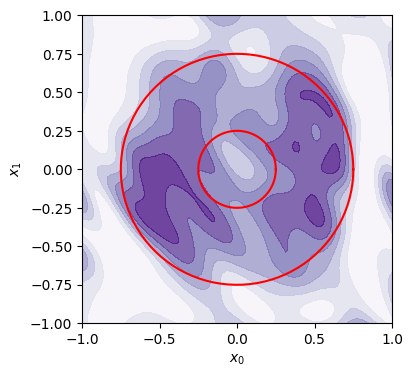

In [20]:
plt.figure(figsize=(4, 4))
plt.contourf(linsp, linsp, Z, cmap="Purples", alpha=0.8)
circle_linsp = jnp.linspace(0, 2 * jnp.pi, 100)
plt.plot(inner_rad * jnp.cos(circle_linsp), inner_rad * jnp.sin(circle_linsp), c="red")
plt.plot(outer_rad * jnp.cos(circle_linsp), outer_rad * jnp.sin(circle_linsp), c="red")
plt.xlabel(f'$x_0$')
plt.ylabel(f'$x_1$');

Looks good, it has clearly grasped the donut shape. Sincerest apologies if you are now hungry! 🍩